# Multigrid

Multigrid is one of the great algorithms for numerically solving PDEs; it is one of the few essentially optimal algorithms for solving a linear system of equations, since it computes the solution of an $N\times N$ system in ${\mathcal O}(N\log(N))$ -- or even just ${\mathcal O}(N)$ -- operations.  

This notebook is meant to accompany a reading of [Section 4.6 of Randall LeVeque's text on finite difference methods](http://0-epubs.siam.org.library.kaust.edu.sa/doi/abs/10.1137/1.9780898717839.ch4).  Other good resources are cited there.

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
#from clawpack.visclaw.JSAnimation import IPython_display
from IPython.display import HTML

## Jacobi's Method
Let's use Jacobi's method to solve the problem given by Eq. (4.82) in  the text. In the box below, we set up the grid, the right hand side,  the boundary values, and the true solution $u$.  

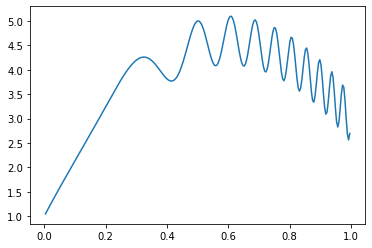

In [14]:
m=2**8-1                              # Number of grid points
h=1./(m+1)                         # Mesh width
x=np.linspace(0,1,m+2); x=x[1:-1]  # grid
phi = lambda x: 20.* np.pi * x**3
f = lambda x: -20 + 0.5*120*np.pi*x * np.cos(phi(x)) - 0.5*(60*np.pi*x**2)**2 * np.sin(phi(x))
alpha=1.; beta=3.
u_exact = lambda x: 1.+12.*x-10.*x**2 + 0.5*np.sin(phi(x))  # Exact solution on computational grid

plt.plot(x,u_exact(x));

Now we'll take 100 iterations with Jacobi's method and plot the result. Notice how we modify $F$ to incorporate the boundary conditions.  

In [15]:
omega = 1.
U=np.linspace(alpha,beta,m)  # Just use a straight line as initial guess
UU=[U]
F=0.5*h**2*f(x)
F[0]-=alpha/2.; F[-1]-=beta/2.    # Construct the RHS, including boundary conditions
e=np.ones(m-1)
G=0.5*(np.diag(e,-1)+np.diag(e,1))
niter=100

for i in range(niter):
    U=(1.-omega)*U+omega*(np.dot(G,U)-F)
    UU.append(U)

The parameter `omega` in the code above is the under-relaxation parameter mentioned in the text.  By setting it to 1 for now, we have the original Jacobi method.

In [16]:
xf = np.linspace(0,1,1000); 
uf = 1.+12.*xf-10.*xf**2 + 0.5*np.sin(phi(xf))  # Exact solution on fine grid
u = 1.+12.*x-10.*x**2 + 0.5*np.sin(phi(x))  # Exact solution on computational grid
fig = plt.figure();

def underrelaxed_jacobi(i):
    ax = plt.axes(xlim=(0, 1), ylim=(-3, 6))
    ax.plot(xf,uf,lw=2)
    ax.plot(x,UU[i],'-',lw=2)
    ax.plot(x,UU[i]-u,'-',lw=2)
    plt.legend(['Exact','Jacobi','Error'],loc=2)
    ax.set_title('# of iterations: '+str(i),fontsize=15);

    #line1.set_data(x,UU[i])
    #line2.set_data(x,UU[i]-u)
    #return line1, 

interact(underrelaxed_jacobi,i=widgets.IntSlider(min=0,max=niter,value=0));

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=0, description='i'), Output()), _dom_classes=('widget-interact',))

Play with the animation above and notice how the high-frequency components of the error are damped very quickly, but the low-frequency error barely changes.  This is because the matrix $G$ appearing in Jacobi's method is tridiagonal, so in a single iteration each solution point only 'feels' the values of its immediate neighbors.  It takes very many iterations for low-frequency information to propagate.  As we'll see, part of the power of multigrid lies in enabling information to propagate rapidly between distant points in the solution.

### Under-relaxation
Try playing around with the number of Jacobi iterations and see how the error changes. Remember that the $p$th Fourier mode  
$$u^p = \sin(p\pi x)$$  
is reduced by a factor of 

$$|\hat{\gamma}_p|= |1-\omega + \omega\cos(p\pi h)| = 1 + \omega(\cos(p \pi h) - 1)|.$$
  
The code below plots this range of values. Try changing $\omega$ to $\frac{2}{3}$ and notice how the second half of the eigenvalues (for $p\ge m/2$) are all shifted to have smaller absolute value.  

In [17]:
M=30; H=1./(M+1)
omegas=np.linspace(0.,1.)
p=np.arange(1,M+1)
fig = plt.figure()

def damping(omega):
    ax = plt.axes(xlim=(0, M), ylim=(0,1))
    ax.set_xlabel('p', fontsize=15)
    ax.set_ylabel('$\hat{\gamma}$', fontsize=20)
    line1, = ax.plot([],[],'o')
    gamma = abs(1.+omega*(np.cos(p*np.pi*H)-1))
    line1.set_data(p,gamma)
    ax.set_title('$\omega = %02.2f $' % omega, fontsize=20)

interact(damping,omega=widgets.FloatSlider(min=0,max=1,step=0.01,value=0,description=r'$\omega$'));

<Figure size 432x288 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='$\\omega$', max=1.0, step=0.01), Output()), _dom_cla…

If you're really observant, you'll notice that for $\omega=1$ the highest frequencies are also not damped much.  Can you choose a different $f$ or a different grid size above so that some very high-frequency modes appear to remain in the error?

### Grid representations of a given frequency
The code below plots a mode of a certain frequency, and then shows how it is represented on grids with decreasing numbers of points.  Notice how a *low frequency* mode (i.e., one with many points per wavelength) on a fine grid becomes a *high frequency* mode (one with very few points per wavelength).

Eventually, on grids with very few points, the mode is *aliased* to a completely different mode.

In [18]:
xf=np.linspace(0,1,1000) # fine grid
fig = plt.figure()

def sine_on_grid(m,p):
    ax = plt.axes(xlim=(0, 1), ylim=(-1.2, 1.2))
    ax.plot(xf, np.sin(p*np.pi*xf), '-r', lw=2)
    x=np.linspace(0,1,m+2); # grid
    ax.plot(x,np.sin(p*np.pi*x),'o-',lw=2)
    ax.set_title('$\sin($'+str(p)+'$\pi x)$ with m='+str(m)+' points',fontsize=20)

interact(sine_on_grid,m=widgets.IntSlider(min=1,max=63,value=63),
         p=widgets.IntSlider(min=0,max=50,value=5));

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=63, description='m', max=63, min=1), IntSlider(value=5, description='p',…

### Restriction and Prolongation
The multigrid idea is to solve successively on different grids, so that every mode has a small damping factor $\hat{\gamma}$ on some grid.

In order to implement multigrid, we need a way to take a function with values on a fine grid and restrict it to its values on a coarser grid (restriction). We also need a way to take a function with values on a coarse grid and interpolate onto a fine grid (prolongation). The functions below do just this, using linear interpolation in the case of the prolongation operator. Make sure you understand what they are doing. You may find it helpful to look up slicing notation in the NumPy help online.  

In [19]:
def coarsen(f):
    return f[1::2]  # This slicing just takes the odd-numbered points

def interpolate(f,alpha,beta):
    m_coarse=len(f)
    m_fine  =2*m_coarse+1
    f_interp = np.zeros(m_fine)
    f_interp[1::2]=f                          #Set the values of the odd numbered points
    f_interp[2:-1:2]=0.5*(f[:-1]+f[1:])       #Set the values of the (interior) even numbered points
    f_interp[0]=0.5*(f_interp[1]+alpha)     #Set the values of the endpoints
    f_interp[-1]=0.5*(f_interp[-2]+beta)
    return f_interp

### Correction using a second grid

Now we compute the residual $$r = f-AU$$ on the fine grid, coarsen it, and solve $$Ae=-r$$ for the approximate error on the coarse grid. Then interpolate and subtract the interpolated error from the fine grid solution.  

225.11248537322513
127
-5.018941402544655e-05


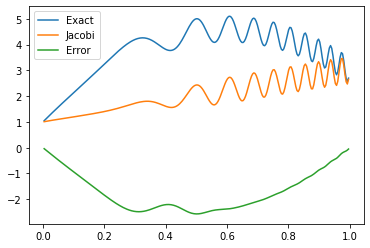

In [20]:
#compute the residual
A=2./h**2*(G-np.eye(m))
F=f(x); F[0]-=alpha/h**2; F[-1]-=beta/h**2
r=F-np.dot(A,U)
print(max(abs(r)))
omega=2./3.
m2=(m-1)//2              # Number of points in coarse grid
print(m2)
h2=1./(m2+1)              # coarse mesh width
x2=coarsen(x)             # coarse grid points
r2=coarsen(r)             # residual restricted to coarse grid
err2=np.zeros(m2)         # initial guess for the error
e2=np.ones(m2-1); G2=0.5*(np.diag(e2,-1)+np.diag(e2,1))
for i in range(3):                        #Solve Ae=-r by Jacobi iteration
    err2=(1.-omega)*err2+omega*(np.dot(G2,err2)+0.5*h2**2*r2)
err=interpolate(err2,0,0)     # interpolate the error
print(err[0])
U=U-err                   # and use it to correct our solution
plt.clf()
plt.plot(x,u,x,U,x,U-u)
plt.legend(['Exact','Jacobi','Error'],loc='best');

Finally, in order to keep our multigrid code clean, we'll write a function to set up and take a fixed number of Jacobi iterations. The function returns the approximate solution and the residual.  

In [21]:
def Jacobi(U,f,alpha,beta,m,nu):
    """Perform nu Jacobi iterations on a grid with m points, with initial guess U, right hand side function f and 
       Dirichlet boundary conditions with values alpha and beta.  The function returns both the approximate
       solution and the residual."""
    omega=2./3.
    h=1./(m+1)
    F=0.5*h**2*f.copy()
    F[0]-=alpha/2.; F[-1]-=beta/2.
    e=np.ones(m-1)
    G=0.5*(np.diag(e,-1)+np.diag(e,1))
    for i in range(nu):
        U=(1.-omega)*U + omega*(np.dot(G,U)-F)
    A=2./h**2*(G-np.eye(m))
    FF=f.copy(); FF[0]-=alpha/h**2; FF[-1]-=beta/h**2
    rr=FF-np.dot(A,U)
    return U,rr

<strong>Multigrid V-cycle</strong>  
Now let's do a full V-cycle. Look carefully through the code below until you understand what it does.  

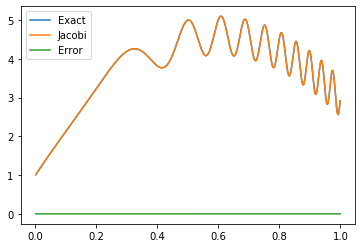

In [22]:
k=10;
m=2**k-1
rdep=k-1  # Recursion depth; this is how many grids down we want to go
          # rdep=k-1 gives a full V-cycle
nu=5      # Number of Jacobi iterations to take at each step
U=np.linspace(alpha,beta,m)  # Initial guess
x=np.linspace(0,1,m+2); x=x[1:-1]  # grid
phi = lambda x: 20.* np.pi * x**3
u = 1.+12.*x-10.*x**2 + 0.5*np.sin(phi(x))
f = lambda x: -20 + 0.5*120*np.pi*x * np.cos(phi(x)) - 0.5*(60*np.pi*x**2)**2 * np.sin(phi(x))
alpha=1.; beta=3.
F=f(x)
r=[None]*(rdep+1); error=[None]*(rdep+1)        # This just initializes these lists to have the right length
U,rr=Jacobi(U,F,alpha,beta,m,nu)  # Initial iteration on fine grid
for i in range(1,rdep+1): # Going down
    m=(m-1)//2 #  = 2**(k-i) - 1
    r[i]=coarsen(rr)             # residual restricted to next coarser grid
    error[i],rr=Jacobi(np.zeros(m),-r[i],0.,0.,m,nu)
for i in range(1,rdep): # Coming up
    m=2*m+1
    err=error[rdep-i]-interpolate(error[rdep+1-i],0,0)     # Interpolate and subtract the correction
    error[-i-1],rr=Jacobi(err,-r[rdep-i],0.,0.,m,nu)
m=2*m+1
U=U-interpolate(error[1],0,0)                   # final solution correction
U,rr=Jacobi(U,F,alpha,beta,m,nu)                #Final iterations on original grid
plt.clf()
plt.plot(x,u,x,U,'-',x,U-u)
plt.legend(['Exact','Jacobi','Error'],loc='best')

Since we have saved the errors on each grid, we can plot them to see how they represent the accumulation of errors at different scales.

In [23]:
%%capture
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-5,5))
line1, = ax.plot([],[],'-ok',lw=2)

def fplot(i):
    y = np.zeros(len(error[-i])+2)
    y[1:-1] = error[-i]
    m = len(y)
    x=np.linspace(0,1,m);
    line1.set_data(x,y)
    return line1, 

anim = animation.FuncAnimation(fig, fplot, frames=range(1,len(error)))

NameError: name 'animation' is not defined

In [24]:
HTML(anim.to_jshtml())

NameError: name 'anim' is not defined

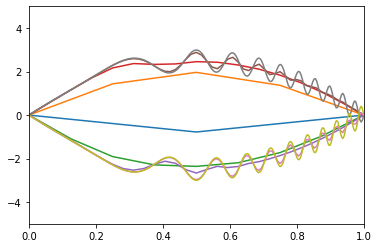

In [25]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-5,5))
line1, = ax.plot([],[],'-ok',lw=2)

def fplot(i):
    y = np.zeros(len(error[-i])+2)
    y[1:-1] = error[-i]
    m = len(y)
    x=np.linspace(0,1,m);
    ax.plot(x,y)

for i in range(1,len(error)):
    fplot(i)

### Conclusion

Now you have the basic ideas of multigrid.  Of course, for this 1-dimensional problem (where the system to be solved is tridiagonal) it does not provide a big advantage over more naive methods.  The power of multigrid is that it can be used in multiple dimensions, where the algebraic system is much more challenging for other methods.  Furthermore, multigrid can be applied to nonlinear and time-dependent problems.

# Exercise #11:
Modify the V-cycle code above to answer the following questions. Try to explain your results.  
(a) How does the accuracy change as we change the number of Jacobi iterations performed at each step?  

(b) Is it better to use a finer grid, or more Jacobi iterations if we want to improve the solution accuracy?  

(c) What happens if we don't perform any Jacobi iterations in the "up" part of the V-cycle?  

(d) What happens if we don't recurse all the way down to the 1-point grid?  

(e) What happens if we use the original Jacobi method, or some other value of $\omega$?  

# Exercise #12
Use the V-cycle code above to implement the full multigrid algorithm discussed in the text. You will probably find it helpful to write a Vcycle() function first.    